# Recommendation System

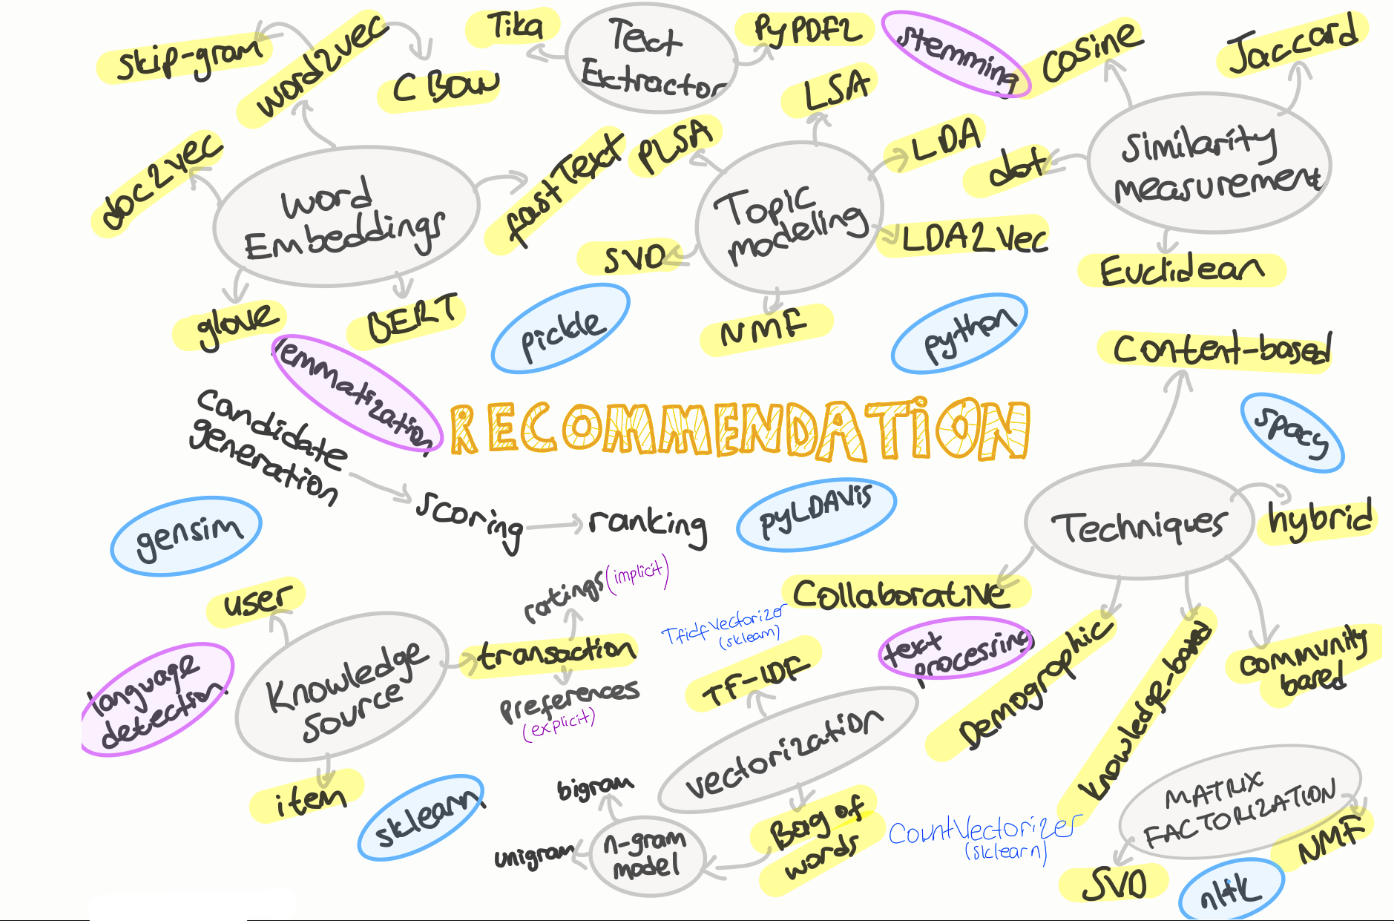

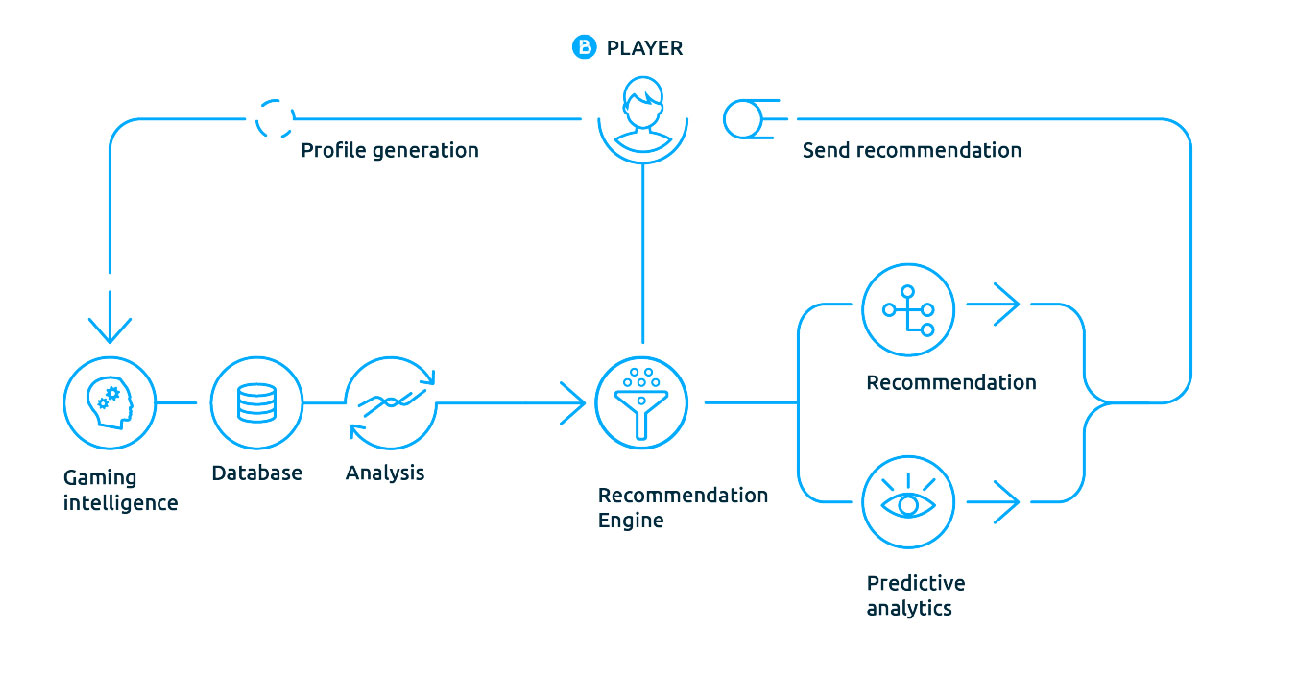

## Dataset Information

Million Songs Dataset contains of two files: 
 triplet_file and metadata_file. 

1. The triplet_file contains **User_Id, Song_Id and Listen Counts**. 

2. The metadata_file contains **Track_Id, Song_Id, Artist_Name, Title**.

Million Songs Dataset is a mixture of song from various website with the rating that users gave after listening to the song.

There are 3 types of recommendation system: content-based, collaborative and popularity.

## Important Libraries

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

## Importing Data

In [2]:
unique_track= pd.read_csv("unique_tracks.txt",sep = "<SEP>", names = ["Track_Id","Song_Id","Artist_Name","Title"])
unique_track.head(2)

,Track_Id,Song_Id,Artist_Name,Title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan


In [5]:
triplet = pd.read_csv("kaggle_visible_evaluation_triplets.txt", sep = '\t', names = ["user", "song", "play_count"])
triplet.head()

,user,song,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


## Explorartory Data Analyses

In [13]:
print("Rows, Column of unique_track data after seperation is :" ,unique_track.shape)
print("Rows, Column of triplet data after seperation is :" ,triplet.shape)

Rows, Column of unique_track data after seperation is : (1000000, 4)
Rows, Column of triplet data after seperation is : (1060635, 3)


### This dataset is really large, let's see unique values in features

Unique_track

In [41]:
print("Unique Song ID's in unique track data are:", len(unique_track["Song_Id"].unique()))
print("Unique Artist Names in unique track data are:", len(unique_track["Artist_Name"].unique()))
print("Unique Titles in unique track data are:", len(unique_track["Title"].unique()))

Unique Song ID's in unique track data are: 999056
Unique Artist Names in unique track data are: 72665
Unique Titles in unique track data are: 702060


In [43]:
print("Unique users in triplet data are:", len(triplet["user"].unique()))
print("Unique songs in triplet data are:", len(triplet["song"].unique()))
print("Unique play_counts in triplet data are:", len(triplet["play_count"].unique()))

Unique users in triplet data are: 99681
Unique song in triplet data are: 30000
Unique play_counts in triplet data are: 299


### Let's see Kernel Density Estimate which is used for visualizing the Probability Density 

1.Unique_track Data

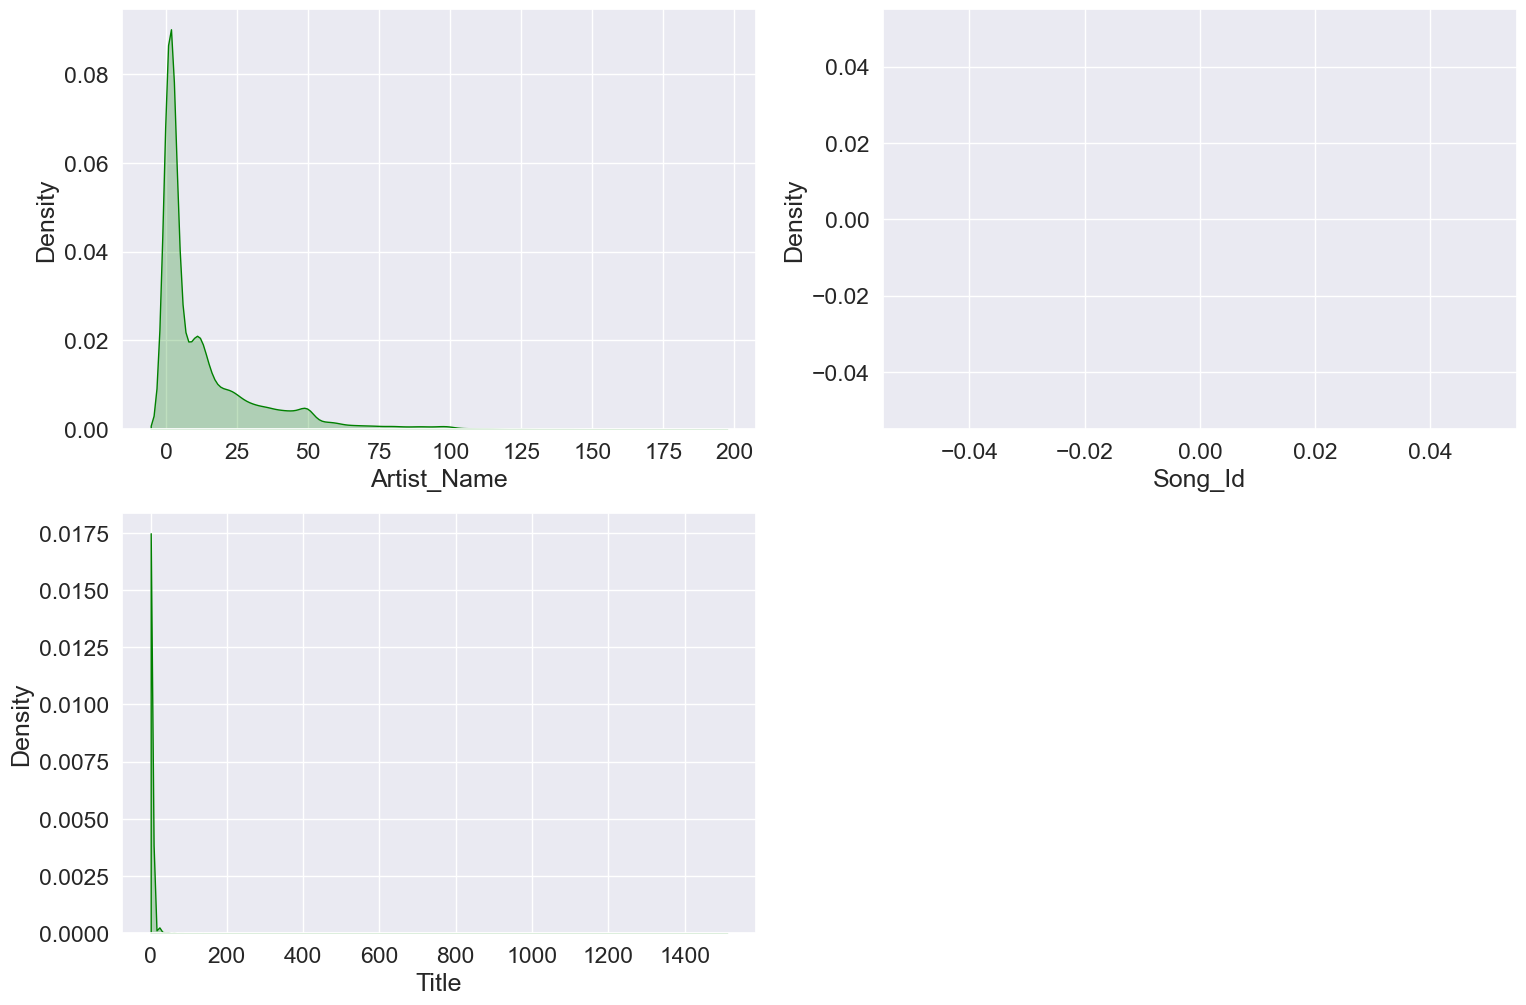

In [83]:
fig = plt.figure(figsize=(18, 12))

a1 = fig.add_subplot(221)
f1=sns.kdeplot(data=unique_track,shade = True, color = 'green', x=unique_track["Artist_Name"].value_counts())

a2 = fig.add_subplot(222)
f1=sns.kdeplot(data=unique_track,shade = True, color = 'green', x=unique_track["Song_Id"].value_counts())

a1 = fig.add_subplot(223)
f1=sns.kdeplot(data=unique_track,shade = True, color = 'green', x=unique_track["Title"].value_counts())

2.Triplet Data

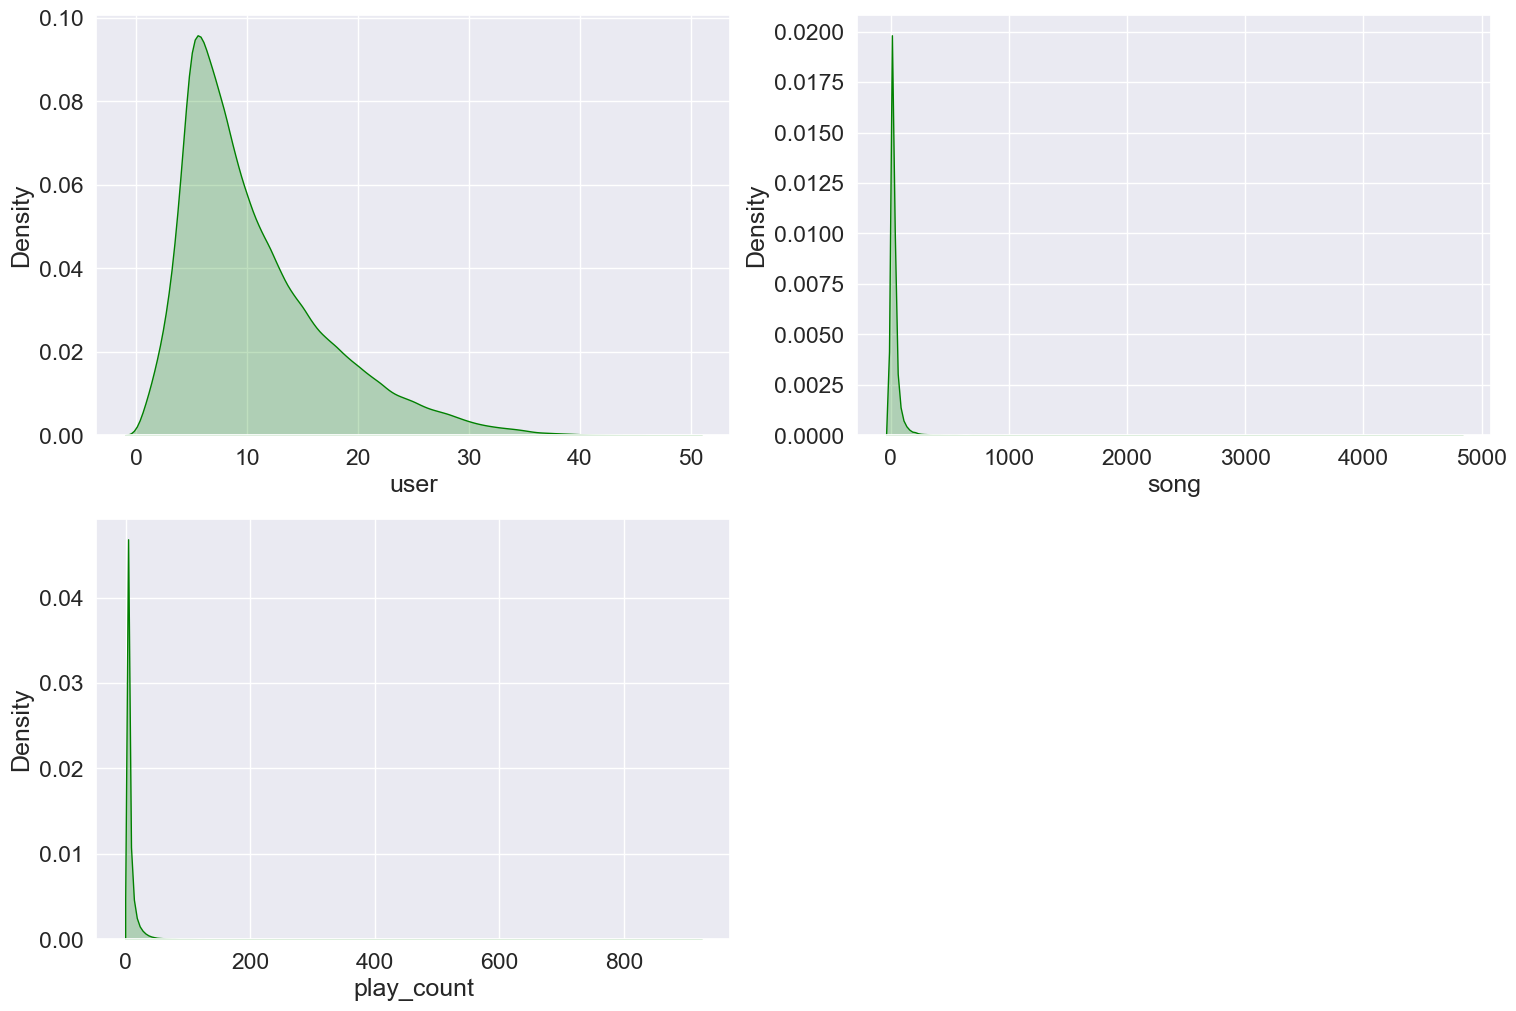

In [70]:
fig = plt.figure(figsize=(18, 12))

a1 = fig.add_subplot(221)
f1=sns.kdeplot(data=triplet,shade = True, color = 'green',  x=triplet["user"].value_counts())

a2 = fig.add_subplot(222)
f1=sns.kdeplot(data=triplet,shade = True, color = 'green', x=triplet["song"].value_counts())

a1 = fig.add_subplot(223)
f1=sns.kdeplot(data=triplet, shade = True, color = 'green', x=triplet["play_count"])

### Lets merge both of the dataset and proceed with EDA then

In [13]:
unique_track.drop_duplicates(["Song_Id"], inplace = True)

In [14]:
song_data = pd.merge(triplet, unique_track, left_on='song', right_on ='Song_Id', how='left')
song_data.head(2)

,user,song,play_count,Track_Id,Song_Id,Artist_Name,Title
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,SOBONKR12A58A7A7E0,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,SOEGIYH12A6D4FC0E3,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...


In [15]:
song_data.drop(["song"], axis = 1, inplace = True)

In [16]:
print("Row, Column:", song_data.shape)

Row, Column: (1450933, 6)


### Lets describe the data

In [17]:
song_data.describe().T

,count,mean,std,min,25%,50%,75%,max
play_count,1450933.0,3.187149,7.051664,1.0,1.0,1.0,3.0,923.0


In [18]:
song_data.describe(include = "O").T

,count,unique,top,freq
user,1450933,110000,7d90be8dfdbde170f036ce8a4b915440137cb11c,53
Track_Id,1450933,163206,TRDMBIJ128F4290431,5043
Song_Id,1450933,163206,SOFRQTD12A81C233C0,5043
Artist_Name,1450933,28361,Coldplay,12279
Title,1450932,137626,Sehr kosmisch,5043


#### Check missing values

In [19]:
print("Total Number of Null Value in data:", song_data.isnull().sum().sum())

Total Number of Null Value in data: 1


In [20]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    song_data.user[song_data.play_count>200].unique().shape[0],
    song_data.play_count[song_data.play_count>200].count()/song_data.shape[0]))
display(song_data.play_count[song_data.play_count>200].describe().reset_index().T)

138 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,154,286.188,102.503,201,221,250,310.25,923


So, as we can see only 138 users listen to a single song more than 200 times, but, would this be possible?

Let's consider that a song has 3:30 minutes in average and create it for the two most obsessed users and check out what their songs are:

In [21]:
lunatic = song_data.play_count[song_data.play_count>song_data.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(song_data[song_data.Song_Id.isin(
                  song_data[song_data.play_count>song_data.play_count.max()-10].Song_Id.values)])

- How much days the most obsessed user can be the fan of a unique song: 2.2


,user,play_count,Track_Id,Song_Id,Artist_Name,Title
1449167,22bb29714137fa47083963c30e1a26f1bf517e7d,923,TRXIHSR12903CC4FA5,SOXTUWG12AB018A2E2,Kilgore,Drop The Hammer (Album Version)


So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

In [22]:
# creating new feature combining title and artist name
song_data['Song'] = song_data['Title']+' - '+song_data['Artist_Name']
song_data.head()

,user,play_count,Track_Id,Song_Id,Artist_Name,Title,Song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRAEHHJ12903CF492F,SOBONKR12A58A7A7E0,Dwight Yoakam,You're The One,You're The One - Dwight Yoakam
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRLGMFJ128F4217DBE,SOEGIYH12A6D4FC0E3,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRTNDNE128F1486812,SOFLJQZ12A6D4FADA6,Cartola,Tive Sim,Tive Sim - Cartola
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRASTUE128F930D488,SOHTKMO12AB01843B0,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,1,TRFPLWO128F1486B9E,SODQZCY12A6D4F9D11,Miguel Calo,El Cuatrero,El Cuatrero - Miguel Calo


### Analysis of Songs

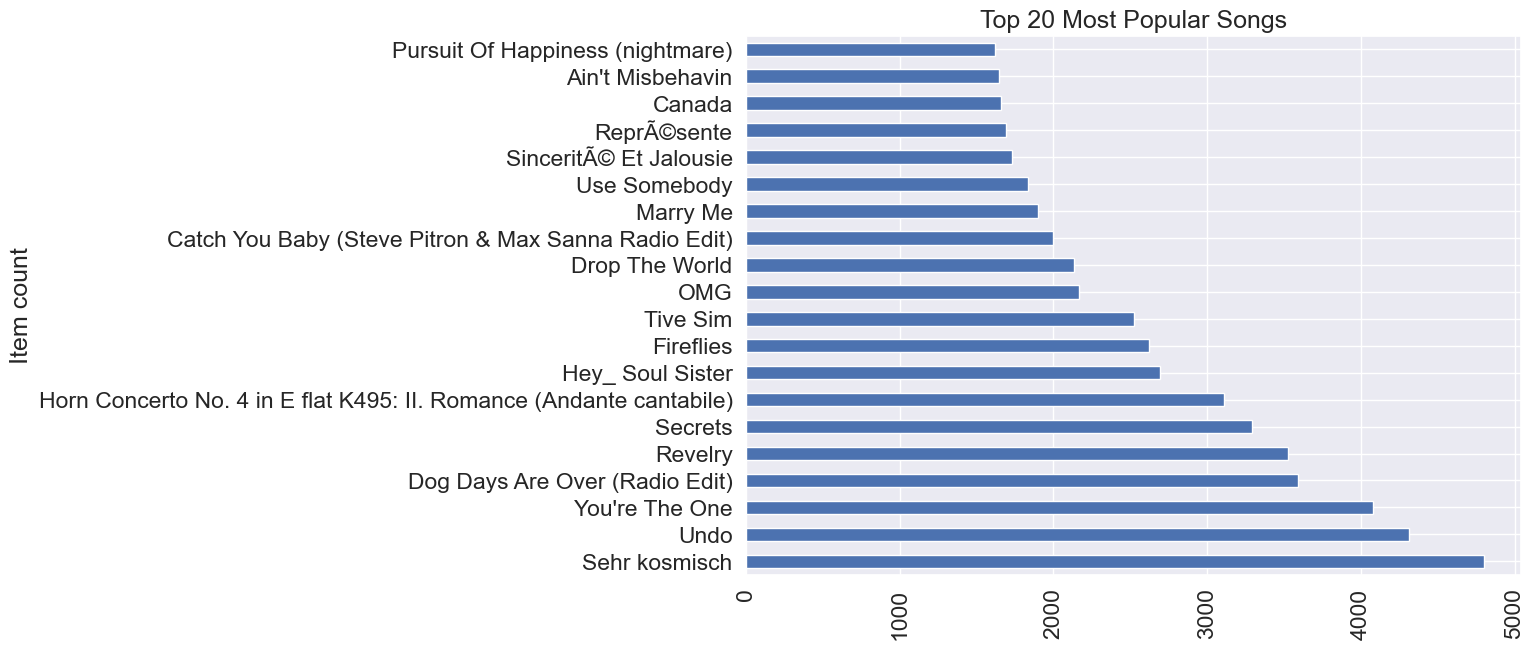

In [230]:
plt.rcParams["figure.figsize"] = (10,7)


popular_songs[:20].plot(kind='barh', title='Top 20 Most Popular Songs', legend=False,)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')


plt.show()

In [231]:
#plt.rcParams["figure.figsize"] = (20,15)
#popular_song_singer = song_data[['Song','play_count']].groupby('Song').sum().\
                #sort_values('play_count', ascending=False).head(20).sort_values('play_count')
#popular_song_singer.plot(kind='barh', title='Top 20 Most Popular Song with Singer', legend=False,)
#plt.xticks(rotation='vertical')
#plt.ylabel('Item count')

#plt.show()

In [193]:
# cummulative sum of listen count of the songs

song_grouped = song_data.groupby(['Song',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index()
song_grouped.head(10) 

,Song,play_count
0,Sehr kosmisch - Harmonia,4801
1,Undo - BjÃ¶rk,4312
2,You're The One - Dwight Yoakam,3980
3,Dog Days Are Over (Radio Edit) - Florence + Th...,3593
4,Revelry - Kings Of Leon,3527
5,Secrets - OneRepublic,3290
6,Horn Concerto No. 4 in E flat K495: II. Romanc...,3113
7,Hey_ Soul Sister - Train,2693
8,Fireflies - Charttraxx Karaoke,2614
9,Tive Sim - Cartola,2526


In [142]:
grouped_sum = song_grouped['play_count'].sum()
song_grouped['percentage']  = song_grouped['play_count'].div(grouped_sum)*100
song_grouped.sort_values(['play_count', 'Song'], ascending = [0,1])

,Song,play_count,percentage
0,Sehr kosmisch - Harmonia,4801,0.452653
1,Undo - BjÃ¶rk,4312,0.406549
2,You're The One - Dwight Yoakam,3980,0.375247
3,Dog Days Are Over (Radio Edit) - Florence + Th...,3593,0.338759
4,Revelry - Kings Of Leon,3527,0.332537
...,...,...,...
29474,You Want - FONZIE,1,0.000094
29314,You'll Understand (Album Version) - Tarnation,1,0.000094
29507,Zaboravi - Neno Belan,1,0.000094
29411,Ã‰chame Un Cable - David Summers,1,0.000094


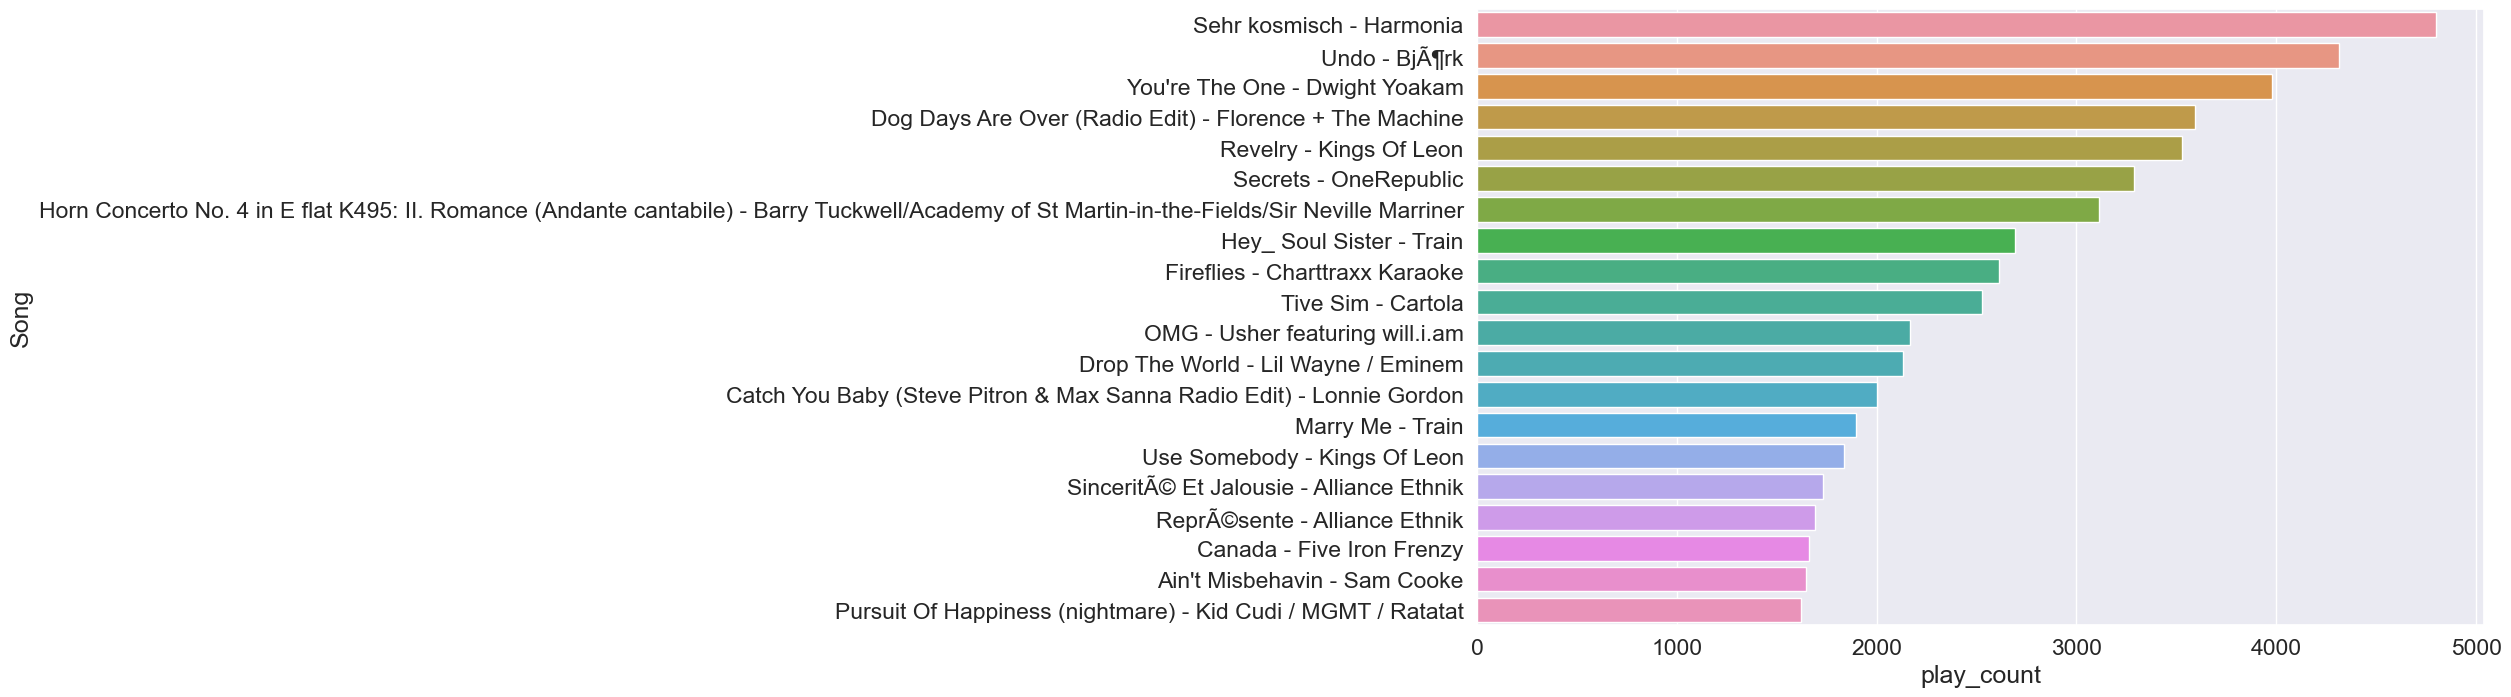

In [234]:
plt.figure(figsize = (13,8))
sns.barplot(y=song_grouped['Song'][:20], x=song_grouped["play_count"])
plt.show()

#### So we have to be careful when creating a recommendation system that can be affected by the outliers. Let's take a look at the top 20 in the different features we have:

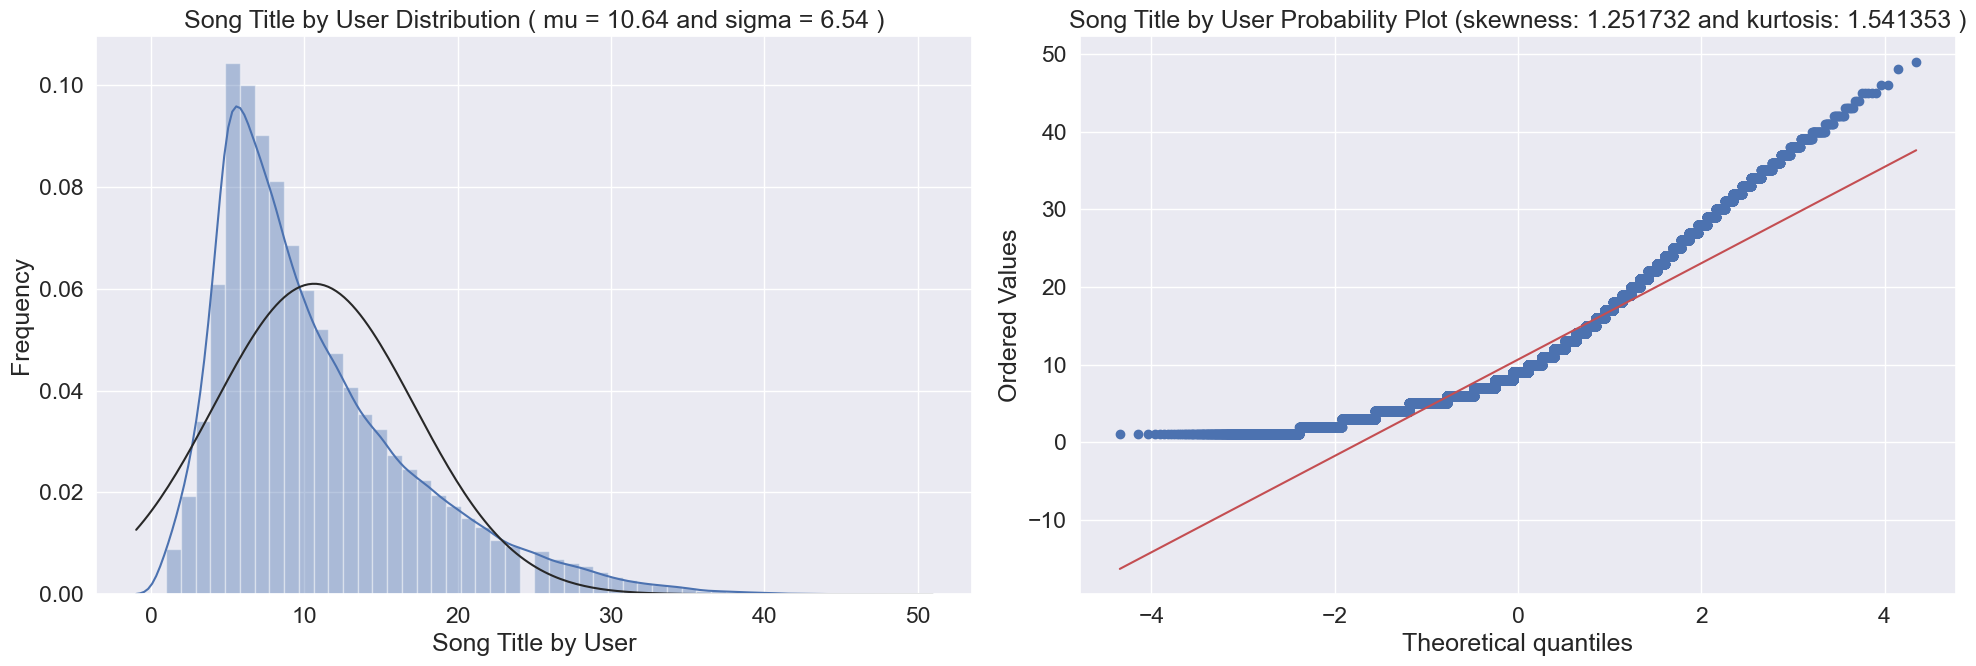

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
Title,99681,10.6403,6.54433,1,6,9,14,49


In [150]:
user_song_count_distribution = song_data[['user','Title']].groupby('user').count().\
                                reset_index().sort_values(by='Title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
QQ_plot(user_song_count_distribution.Title, 'Song Title by User')
user_song_count_distribution.Title.describe().reset_index().T

From the first graph above we can see that song title by user distribution is skewed, has a peak on the left and a long tail to the right. It deviates from normal distribution and is somewhat positively biased.

From the Probability Plot, we could see that song title by user also does not align with the diagonal red line which represent normal distribution. The form of its distribution confirm that is a skewed right.

With skewness positive of 1.25, we confirm the lack of symmetry and indicate that song title by user are skewed right, as we can see too at the song title by user distribution plot, skewed right means that the right tail is long relative to the left tail, as we expect in counts. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with 1.54 of positive kurtosis song title by user are acceptable, although we can accept the kurtosis within 3.

OK, let's take a look at the distribution of the number of times users heard the most popular song.

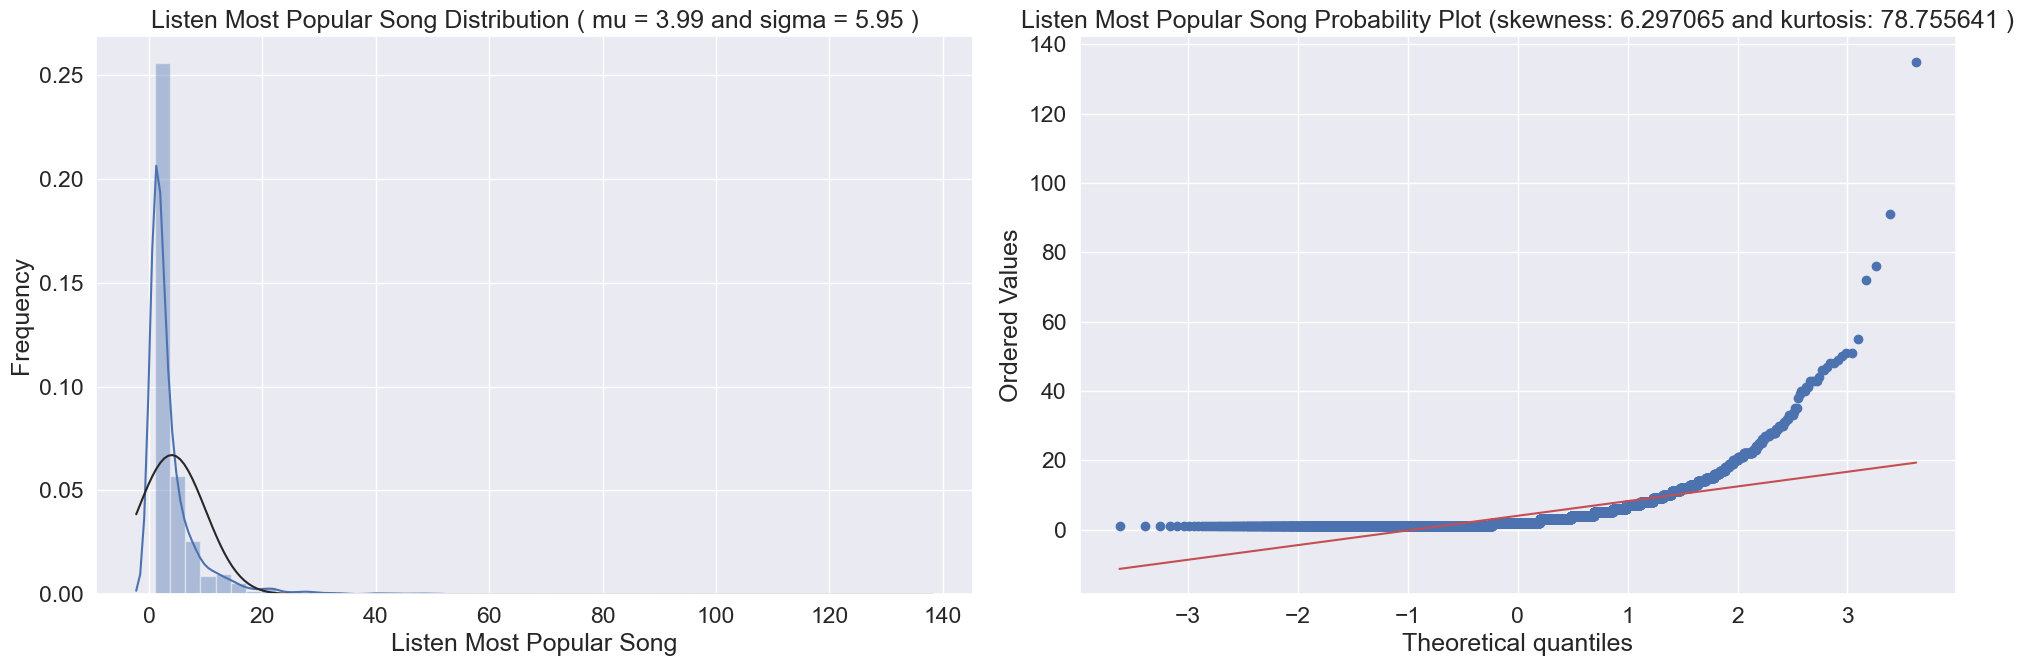

In [159]:
QQ_plot(song_data[song_data["Title"]=="Sehr kosmisch"].play_count, 'Listen Most Popular Song')

Here we can see skewness and kurtosis are high and its positively skewed.

In [169]:
song_data[song_data["Title"]=="You're The One"][["Title"]].value_counts()

Title         
You're The One    4082
dtype: int64

## Analysis of Users

### Lets see how much time user listening a songs

In [181]:
song_per_user = song_data.groupby(['user',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False).reset_index() 

In [182]:
song_per_user

,user,play_count
0,7a1da2cfab87398a137441a85aee84793a376302,49
1,9b0f827c8bad0cf089b0d778307e1b390f463730,48
2,cff21116daa6af7719ed41e4b540feeaf5f31803,46
3,cdf02034d8a63dd8f4b4c22a5e7b225a37bdb844,46
4,ecd8e3aaf27af93873acff818f531f5c5d037dcb,45
...,...,...
99676,fd6cb3d16ab2100757cd44fe1ae027c50465f3ae,1
99677,1d9cceb6ac814ed1936aec0cbf729f0cd4593b64,1
99678,6408f399139d87bf341aea0e900285bf5eaefa62,1
99679,9bc1033d643046479cb4ea04806a113468b9dceb,1


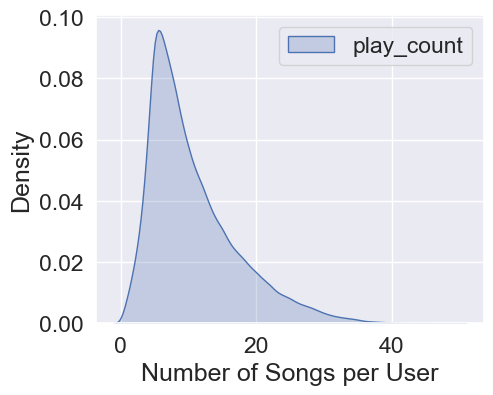

In [190]:
plt.figure(figsize = (5,4))
plt.xlabel("Number of Songs per User")

sns.kdeplot(data=song_per_user,shade = True, color = 'blue' )
plt.show()

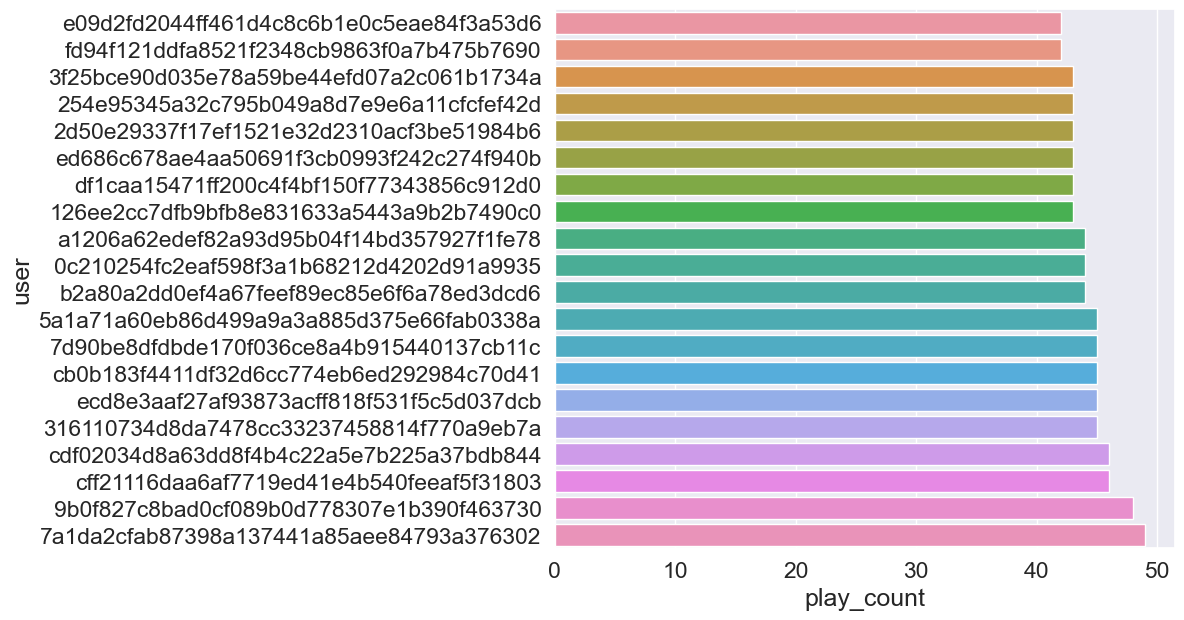

In [252]:
plt.figure(figsize = (8,7))
sns.barplot(y=song_per_user['user'][:20], x=song_per_user["play_count"])
plt.show()

## Analysis of Artist

### Popular Artist

In [254]:
popular_artist = song_data.groupby(['Artist_Name',]).agg({'play_count':'count'}).sort_values('play_count', ascending=False)
popular_artist.head(10)

,play_count
Artist_Name,
Coldplay,11736
Kings Of Leon,8086
Florence + The Machine,7912
Justin Bieber,7368
Jack Johnson,6571
The Black Keys,6288
Train,6288
Eminem,5970
OneRepublic,5773


In [257]:
#song_data[['Artist_Name','play_count']].groupby('Artist_Name').sum().sort_values('play_count', ascending=False)

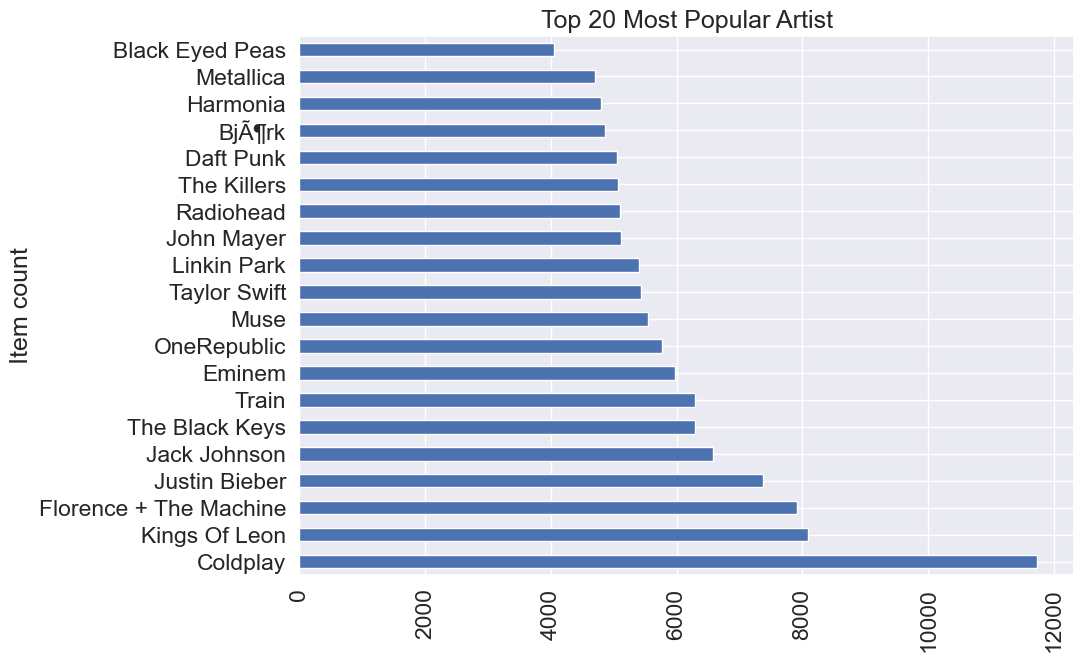

In [259]:
plt.rcParams["figure.figsize"] = (10,7)

popular_artist[:20].plot(kind='barh', title='Top 20 Most Popular Artist', legend=False,)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()

#Popularity Recommender System

In [23]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(song_data, test_size = 0.20, random_state=0)

In [26]:
!pip install Recommender

  ERROR: Could not find a version that satisfies the requirement Recommender (from versions: none)
ERROR: No matching distribution found for Recommender


In [25]:
import Recommender

pr = Recommender.Popularity_Recommender()
pr.create(train_data, 'user_id', 'song')

ModuleNotFoundError: No module named 'Recommender'